In [ ]:
install.packages("BiocManager")
BiocManager::install("WGCNA")

In [2]:
library('WGCNA')#co expression network analysis
library('ggplot2')
library('knitr')
library('limma')
library('reshape2')#manipulating data
library('RColorBrewer')
library('gplots')#visualization, heatmap
library('ggraph')
library('igraph')#network constructions

### Preprocess data

* load data

In [64]:
df = read.csv("C:/Users/sudha.gcupadhaya/Desktop/RNA-seq/RNA seq/network analysis/Solanum_reads.csv",header=T)#read counts data file

In [65]:
df_1 <- data.frame(df[,-1], row.names = df[,1])#change to dataframe
raw_counts = round(df_1, digits = 0)#round the digits

In [66]:
samples <- read.csv('sample.csv')#file with the treatment information
kable(samples)



|sampleid |condition |batch |
|:--------|:---------|:-----|
|S1_1_2_2 |Vd_653    |A     |
|S1_1_2_3 |Vd_653    |A     |
|S1_1_2_6 |Vd_653    |A     |
|S1_2_2_1 |Vd_111    |A     |
|S1_2_2_2 |Vd_111    |A     |
|S1_2_2_4 |Vd_111    |A     |
|S1_3_2_3 |control   |A     |
|S1_3_2_4 |control   |A     |
|S1_3_2_5 |control   |A     |

In [67]:
dim(raw_counts)

[1] 46596     9

In [68]:
head(raw_counts)

,S1_1_2_2,S1_1_2_3,S1_1_2_6,S1_2_2_1,S1_2_2_2,S1_2_2_4,S1_3_2_3,S1_3_2_4,S1_3_2_5
PGSC0003DMG400018887,292,275,200,200,304,185,156,130,125
PGSC0003DMG400047158,0,0,0,0,0,0,0,0,0
PGSC0003DMG400018623,16,18,13,8,12,10,16,18,19
PGSC0003DMG400030952,679,551,661,978,776,791,573,412,509
PGSC0003DMG400000217,18,50,30,4,5,13,66,16,24
PGSC0003DMG400012269,1046,1039,996,1181,1059,1193,648,625,724


* Filter low count

In [69]:
low_count_mask <- rowSums(raw_counts) < ncol(raw_counts)# filter out the genes with low count less than no.of samples

sprintf("Removing %d low-count genes (%d remaining).", sum(low_count_mask), 
        sum(!low_count_mask))
x = raw_counts[!low_count_mask,]#subset the genes 

[1] "Removing 17678 low-count genes (28918 remaining)."

* Log2 transformation

In [70]:
log_counts <- log2(x + 1)#log2 transformation on count data

In [71]:
dim(log_counts)

[1] 28918     9

### Remove the genes not differentially expressed

* Create a matrix for differntial expression analysis

In [72]:
mod <- model.matrix(~0+samples$condition)#create dummy variables for all treatment condition
mod
colnames(mod) <- levels(samples$condition)#rename the mod file with tretment name
mod
fit <- lmFit(log_counts, design=mod)#fit the linear model for each gene and also specify the treatment names in design

samples$conditioncontrol,samples$conditionVd_111,samples$conditionVd_653
0,0,1
0,0,1
0,0,1
0,1,0
0,1,0
0,1,0
1,0,0
1,0,0
1,0,0


control,Vd_111,Vd_653
0,0,1
0,0,1
0,0,1
0,1,0
0,1,0
0,1,0
1,0,0
1,0,0
1,0,0


* Create list of all possible pairwise contrasts

In [73]:
condition_pairs <- t(combn(levels(samples$condition), 2))#create all possible combination for pariwise analysis and transpose it

In [74]:
comparisons <- list()                                                                                                                                          
for (i in 1:nrow(condition_pairs)) {                                                                                                                                     
    comparisons[[i]] <- as.character(condition_pairs[i,])                                                                                                      
}    

In [75]:
comparisons

[[1]]
[1] "control" "Vd_111" 

[[2]]
[1] "control" "Vd_653" 

[[3]]
[1] "Vd_111" "Vd_653"

* Differntially expressed genes

In [76]:
sig_genes <- c()# create a empty vector to append
for (conds in comparisons) {
    # generate string contrast formula, "Vd_653 - Vd_111"
    contrast_formula <- paste(conds, collapse=' - ')#one trt minus other

    contrast_mat <- makeContrasts(contrasts=contrast_formula, levels=mod)#it creats the contrast matrix the treatment combinations
    contrast_fit <- contrasts.fit(fit, contrast_mat)#fit linear model to calculate coefficints and standard error for the given contrast
    eb <- eBayes(contrast_fit)#Empirical Bayes statistics for differential expression

    sig_genes <- union(sig_genes, 
                       rownames(topTable(eb, number=Inf,  adjust.method = 'BH', p.value=0.05)))#
}#grab the top genes based on given cutoff value of p
length(sig_genes)

[1] 18247

* Filter out the differentially expressed genes in any contrast

In [77]:
log_counts <- log_counts[rownames(log_counts) %in% sig_genes,]
datExpr = t(log_counts)#transpose the expression data frame

In [78]:
dim(datExpr)


[1]     9 18247

### Construct adjacency matrix

* Convert similarity matrix to adjacency matrix using power transformation
* This helps to remove the spurious correlation in data

In [ ]:
# Choose a set of soft-thresholding powers 
powers = c(c(1:10), seq(from = 12, to=20, by=2)) 

# Call the network topology analysis function 
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5,blockSize=8504) 

 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 8504 of 18247


Warning message:
"executing %dopar% sequentially: no parallel backend registered"

   ..working on genes 8505 through 17008 of 18247
   ..working on genes 17009 through 18247 of 18247


* Construct co-expression adjacency matrix

In [79]:
adj_matrix <- adjacency(datExpr, power=4)#use power to absoulte value of correlation to differentiate weak and strong correlation

In [19]:
dim(adj_matrix)#direct expression

[1] 18247 18247

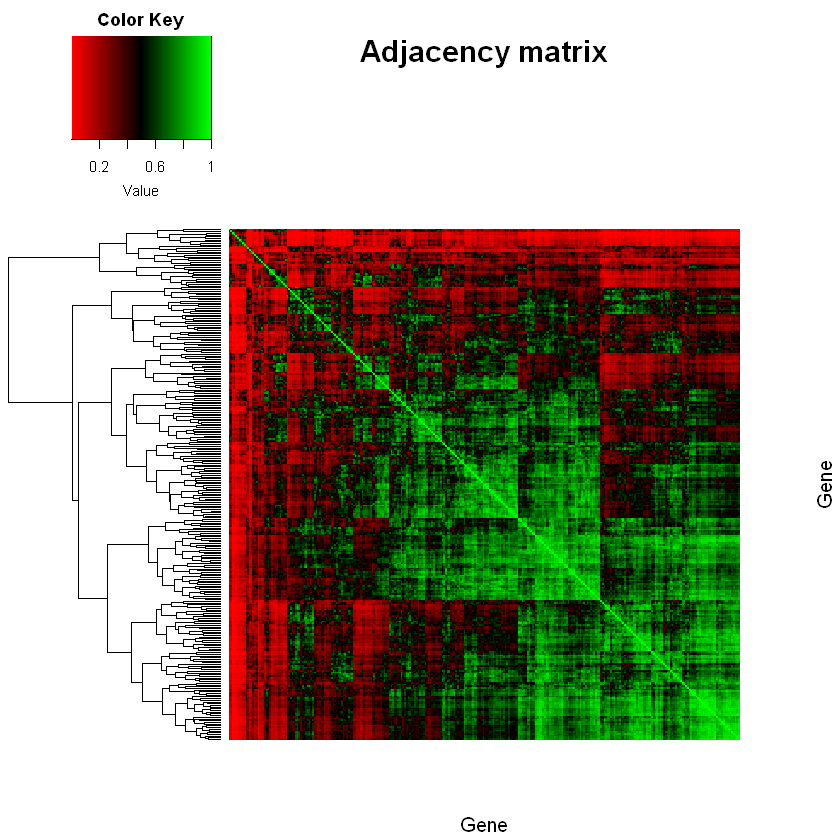

In [67]:
heatmap_indices <- sample(nrow(adj_matrix), 300)
heatmap.2(t(adj_matrix[heatmap_indices, heatmap_indices]),
            col=redgreen(75),
            labRow=NA, labCol=NA, 
            trace='none', dendrogram='row',
            xlab='Gene', ylab='Gene',
            main='Adjacency matrix',
            density.info='none', revC=TRUE)

* Topological overlap matrix (TOP) (helps to minimize noise and spurious associations)

In [80]:
# Turn adjacency into topological overlap
TOM = TOMsimilarity(adj_matrix)
#dissTOM = 1-TOM

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [81]:
rm(adj_matrix)
rm(log_counts)
rm(raw_counts)
rm(df)
rm(df_1)
rm(x)

* Rename column and rows of TOM matrix

In [52]:
gene_ids <- rownames(adj_matrix)
rownames(TOM) <- gene_ids
colnames(TOM) <- gene_ids

* Hierarchical clustering of genes TOM

In [130]:
# Call the hierarchical clustering function
geneTree = hclust(as.dist(1-TOM), method = "average")

* Hierarchial clustering without TOM (Either use TOM or this)

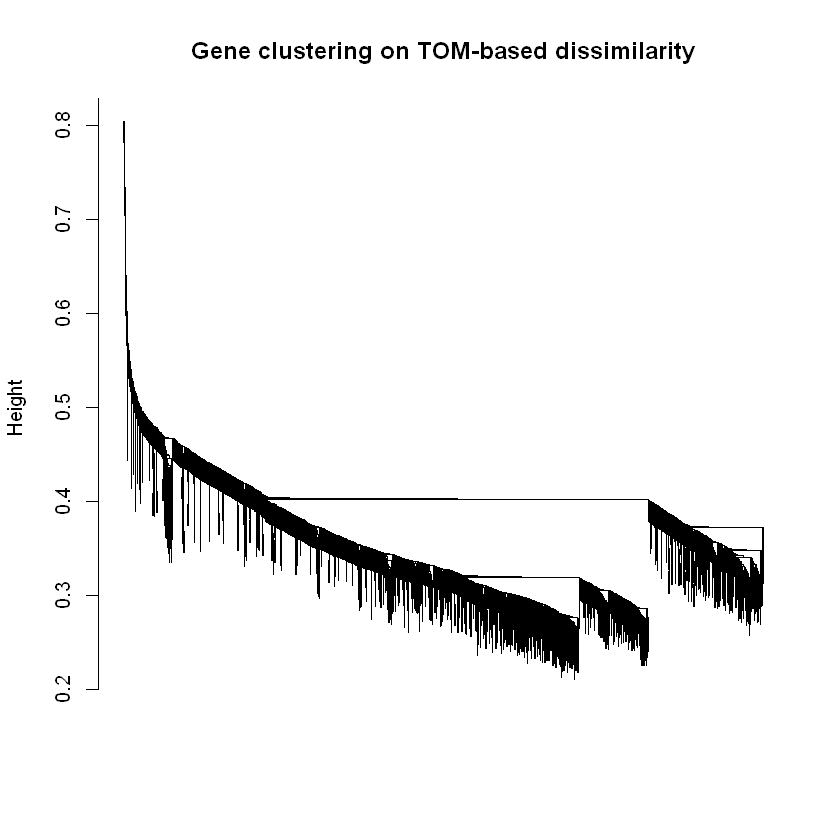

In [131]:
plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
labels = FALSE, hang = 0.04)

* Identify modules

In [132]:
module_labels <- cutreeDynamic(dendro=geneTree, method = 'tree', minClusterSize = 200, deepSplit ='True')
                                   #cut the branches using WAGNA. It cuts the dendrogram into different cluster and modules
module_colors <- labels2colors(module_labels)#change numeric labels to color
table(module_labels)

module_labels
   0    1    2    3 
   1 2091  532  319 

In [133]:
length(unique(module_labels))

[1] 4

In [134]:
unique(module_colors)

[1] "turquoise" "blue"      "brown"     "grey"

* Plot dendrogram with module labels

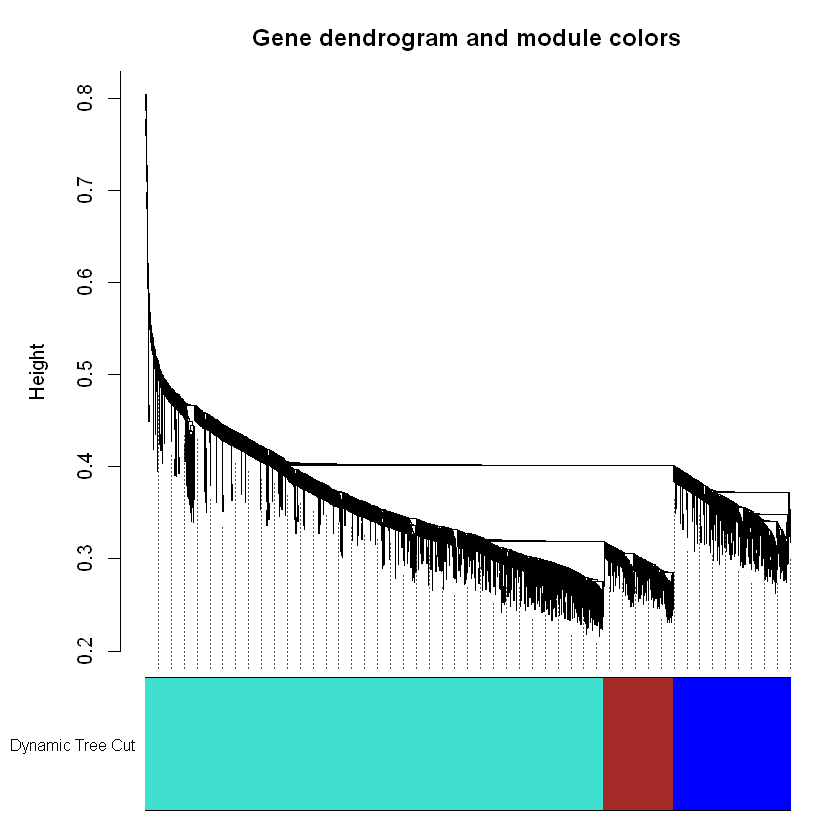

In [135]:
plotDendroAndColors(geneTree, module_colors, "Dynamic Tree Cut",
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05,
main = "Gene dendrogram and module colors")

### Merge modules with similar expression pattern

* Calculate eigengenes for each module

In [136]:
MEList = moduleEigengenes(datExpr, colors = module_colors)
MEs = MEList$eigengenes
MEs

,MEblue,MEbrown,MEgrey,MEturquoise
S1_1_2_2,0.23170572,0.2214474,-0.08420221,0.1841936
S1_1_2_3,0.05049047,0.1623360,-0.40440610,0.2086536
S1_1_2_6,0.13008354,0.1917689,-0.24430415,0.1787364
S1_2_2_1,0.33201244,0.2969100,0.58492584,0.2895087
S1_2_2_2,0.24333173,0.1979601,0.26873071,0.2368081
S1_2_2_4,0.35968139,0.2978597,0.46318997,0.2955640
S1_3_2_3,-0.33269434,-0.2845941,-0.18343622,-0.3728704
S1_3_2_4,-0.54353351,-0.5841814,-0.08420221,-0.5521299
S1_3_2_5,-0.47107744,-0.4995066,-0.31629564,-0.4684641


* Calculate dissimilarity of module eigengenes

In [137]:
MEDiss = 1-cor(MEs);
signif(cor(MEs, use="p"), 2)

,MEblue,MEbrown,MEgrey,MEturquoise
MEblue,1.00,0.99,0.61,0.98
MEbrown,0.99,1.00,0.49,0.99
MEgrey,0.61,0.49,1.00,0.49
MEturquoise,0.98,0.99,0.49,1.00


* Cluster module eigengenes

In [138]:
METree = hclust(as.dist(MEDiss), method = "average")

* Plot the eigengene dendogram

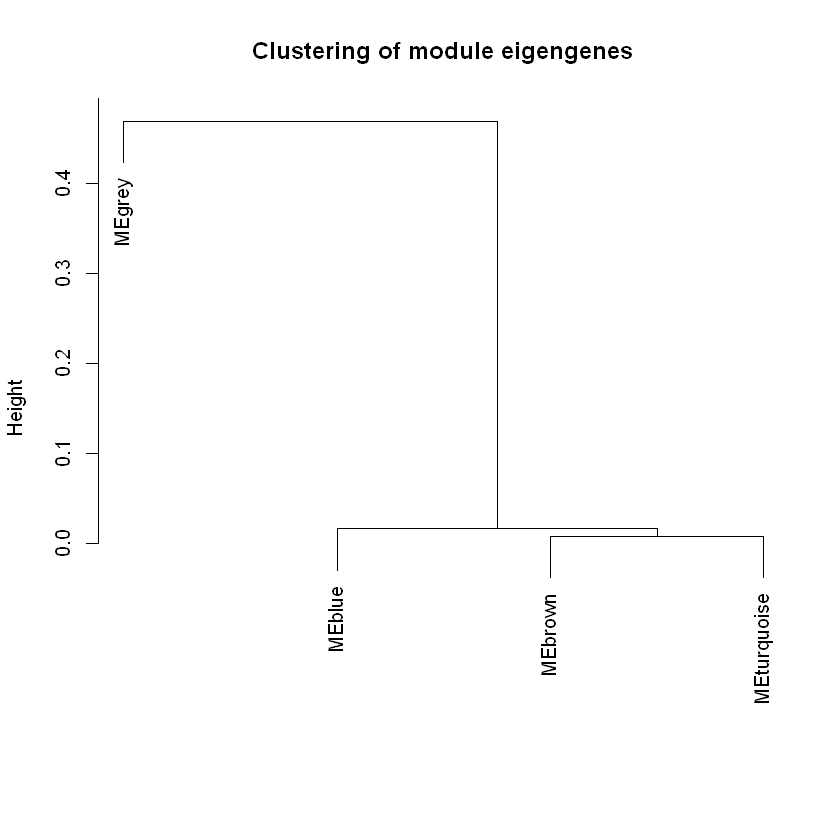

In [139]:
plot(METree, main = "Clustering of module eigengenes",
xlab = "", sub = "")

### Find the modules that relate to the disease

In [140]:
datME = MEs
datME

,MEblue,MEbrown,MEgrey,MEturquoise
S1_1_2_2,0.23170572,0.2214474,-0.08420221,0.1841936
S1_1_2_3,0.05049047,0.1623360,-0.40440610,0.2086536
S1_1_2_6,0.13008354,0.1917689,-0.24430415,0.1787364
S1_2_2_1,0.33201244,0.2969100,0.58492584,0.2895087
S1_2_2_2,0.24333173,0.1979601,0.26873071,0.2368081
S1_2_2_4,0.35968139,0.2978597,0.46318997,0.2955640
S1_3_2_3,-0.33269434,-0.2845941,-0.18343622,-0.3728704
S1_3_2_4,-0.54353351,-0.5841814,-0.08420221,-0.5521299
S1_3_2_5,-0.47107744,-0.4995066,-0.31629564,-0.4684641


#### Correlation between treatment and module eigengene

In [141]:
y =as.numeric(rep(c('0','1','2'), each =3))
y

[1] 0 0 0 1 1 1 2 2 2

In [147]:
test = cor.test(datME$MEturquoise, y) 
test


	Pearson's product-moment correlation

data:  datME$MEturquoise and y
t = -3.5552, df = 7, p-value = 0.009279
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9566620 -0.2955883
sample estimates:
       cor 
-0.8022274 


#### Network construction

In [28]:
library('igraph')
library('network')
#library('networkD3')
#library('intergraph')

#### Co-expression network

**WGCNA**
* Recommended no. of samples: atleast 12
* Selecting differntially expressed genes not recommened since they tend to co-express. 

**What can be done**
* Since, we have 4 different hosts, separate co-expression network analysis has to be done
* Identify significant modules (using correlation analysis between module eigengene and treatments) and do gene enrichment analysis in each modules of each host
* Find what processes are significanlty coexpressed in each module
* Identify the gene hub with in the module for susceptibility

**OR**
* Pick top 30 significantly expressed genes from the DESeq analysis
* Create adjacency matrix based on the correlation of each hosst
* contrust network for those genes only to show the correlation of those highly expressed gens

In [84]:
results = blockwiseModules(datExpr, power =4, MinModuleSize = 500, 
                            TOMType = 'unsigned', deepSplit = TRUE)
length(unique(results$colors))

[1] 7

In [85]:
color = results$colors

In [87]:
#At 0.05(Total 18000genes)
adj_matrix = TOM

In [88]:
rm(TOM)
rm(datExpr)
rm(results)

In [89]:
adj_matrix[adj_matrix > 0.1] <- 1
adj_matrix[adj_matrix != 1] <- 0

In [96]:
adj_matrix = adj_matrix[1:2000, 1:2000]
color = color[1:2000]

In [97]:
network = graph.adjacency(adj_matrix)
network = simplify(network)
V(network)$color = color

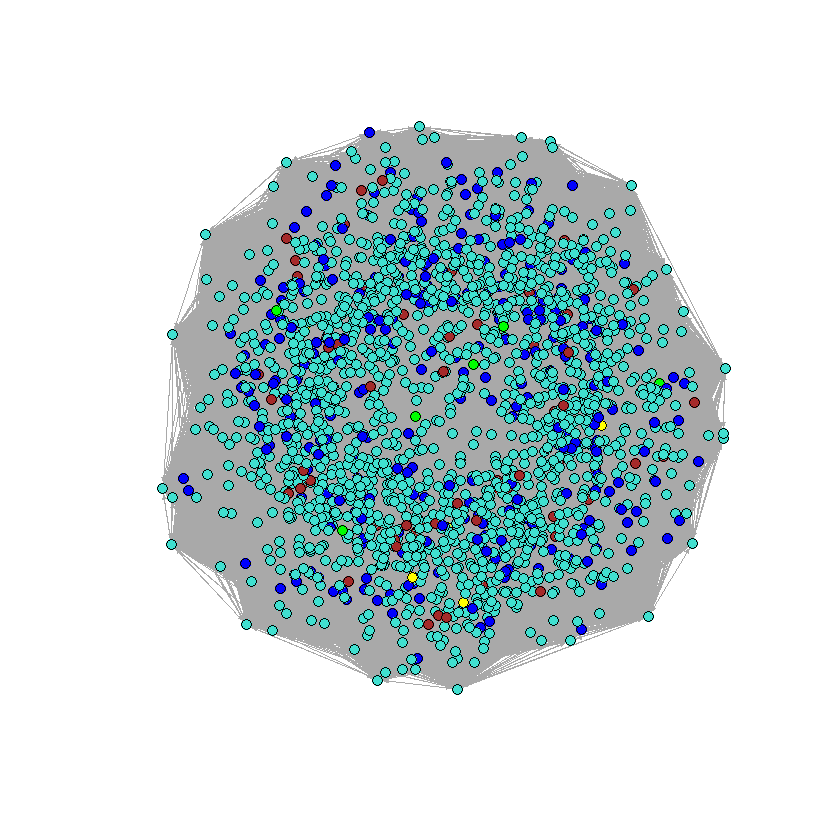

In [101]:
plot(network, layout=layout.fruchterman.reingold(network), edge.arrow.size = 0.2, vertex.label = NA, vertex.size = 4)

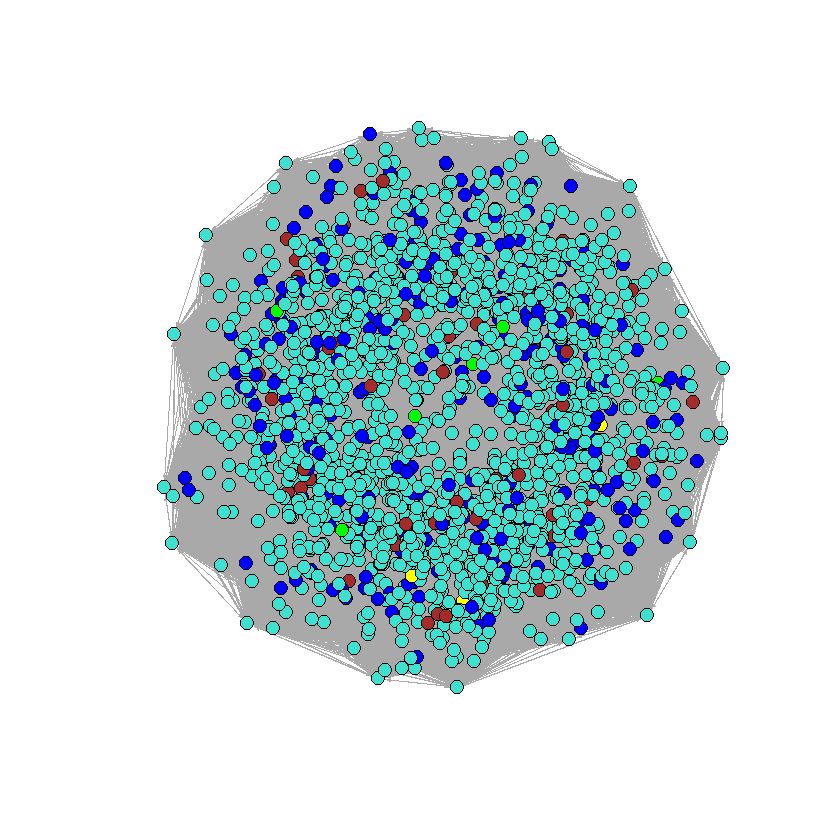

In [99]:
plot(network, layout=layout.fruchterman.reingold(network), edge.arrow.size = 0.2, vertex.label = NA, vertex.size = 5)

In [36]:
memory.limit()

[1] 16194

In [93]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3503757,187.2,6806027,363.5,6806027,363.5
Vcells,339669776,2591.5,1070927522,8170.6,1666786253,12716.6


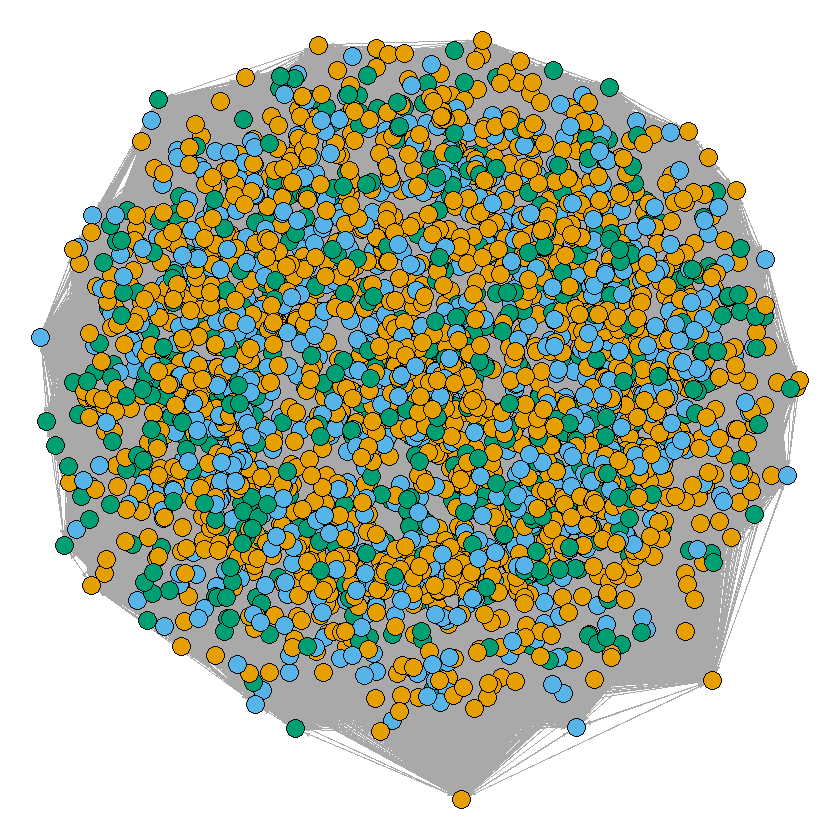

In [203]:
#Total 2900 genes
adj_matrix = TOM
adj_matrix[adj_matrix > 0.1] <- 1
adj_matrix[adj_matrix != 1] <- 0
network = graph.adjacency(adj_matrix)
network = simplify(network)
results = blockwiseModules(datExpr, power =12, MinModuleSize = 5, 
                           mergeCutHeight = 0.005, numericLabels = TRUE, TOMType = 'unsigned', deepSplit = TRUE)
V(network)$color = results$colors
par(mar=c(0,0,0,0))
plot(network, layout=layout.fruchterman.reingold(network), edge.arrow.size = 0.2, vertex.label = NA, vertex.size = 5)

#### Visualize only one module

* combine gene name and corresponding module color

In [158]:
com_genecolor = cbind(as.data.frame(colnames(adj_matrix)), as.data.frame(module_colors))
names(com_genecolor) = c('gene','module')
unique(com_genecolor$module)
head(com_genecolor,7)

[1] turquoise blue      brown     grey     
Levels: blue brown grey turquoise

gene,module
Novel03424,turquoise
PGSC0003DMG400022384,turquoise
PGSC0003DMG400024180,turquoise
PGSC0003DMG400027900,turquoise
PGSC0003DMG401006819,turquoise
PGSC0003DMG400026291,blue
Novel03085,turquoise


In [187]:
brown = subset(com_genecolor, module =='brown')
dim(brown)
module_brown = brown$gene

[1] 2091    2

In [188]:
adj_matrix = TOM
adj_brown = adj_matrix[rownames(adj_matrix) %in% module_brown, colnames(adj_matrix) %in% module_brown] 
dim(adj_brown)

[1] 2091 2091

In [189]:
adj_matrix = adj_brown
adj_matrix[adj_matrix > 0.1] <- 1
adj_matrix[adj_matrix != 1] <- 0
network = graph.adjacency(adj_matrix)
network = simplify(network)

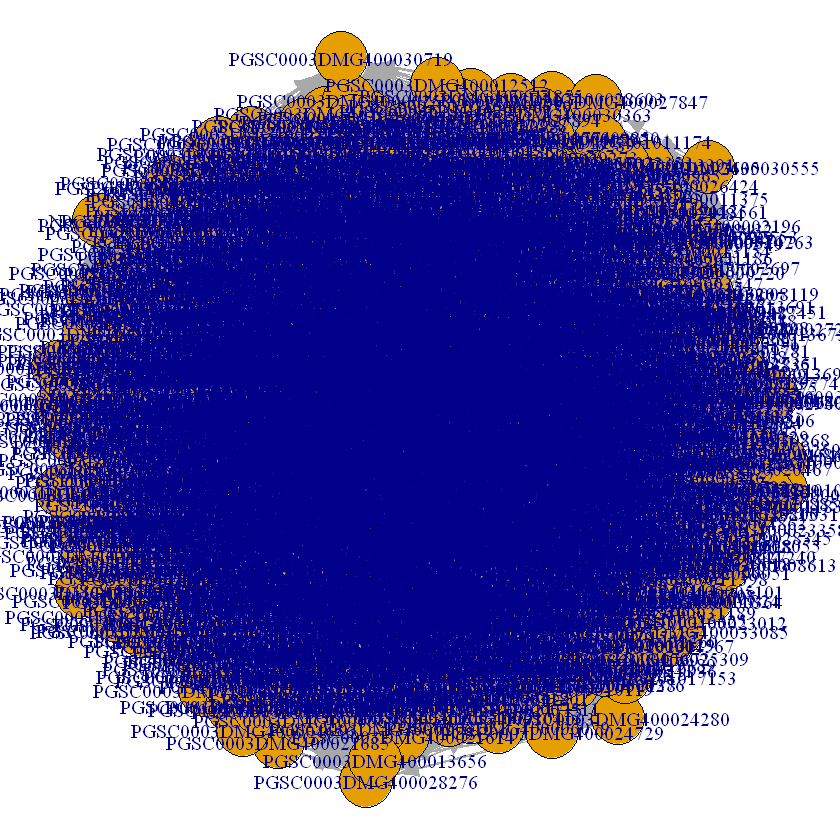

In [190]:
par(mar=c(0,0,0,0))
plot(network)

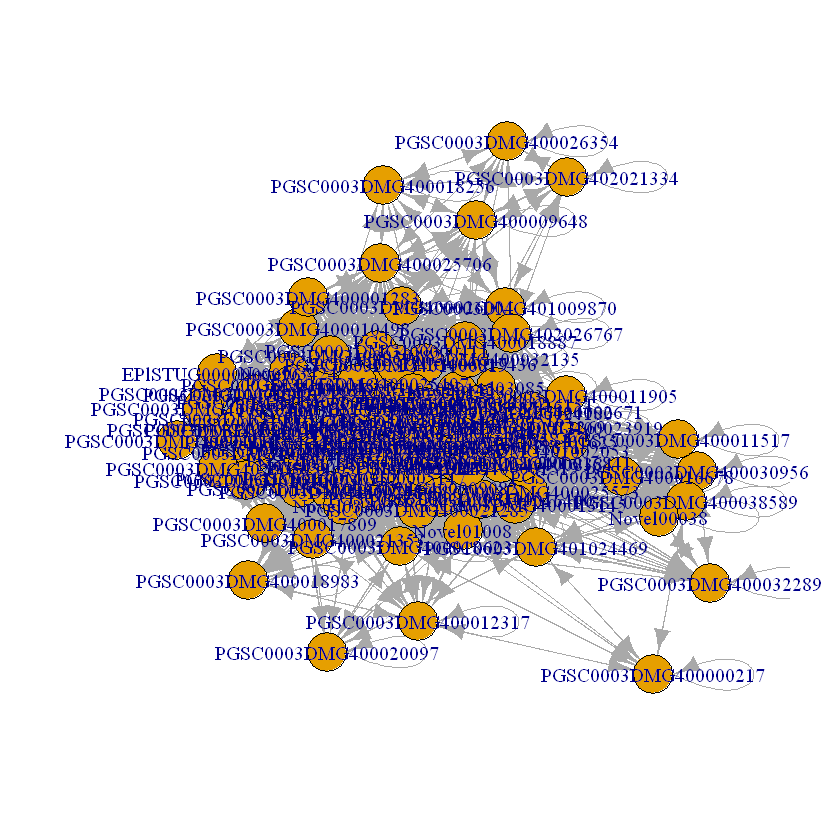

In [35]:
#random
a = graph.adjacency(b)
plot(a)

#### Gene annotation

In [ ]:
library('biomaRt')
library('biomartr')

In [194]:
genes = colnames(adj_matrix)

In [201]:
ensembl <- useMart(biomart = "plants_mart",
                   dataset = "stuberosum_eg_gene",
                   host = "plants.ensembl.org")

features <- getBM(attributes = c("ensembl_gene_id",
                                 'external_gene_name',
                                 "description",
                                 "chromosome_name",
                                 "start_position", 
                                 "end_position"), 
                  filters = c("ensembl_gene_id"),
                  values = genes, 
                  mart = ensembl)
getGFF( db = "genbank",
        organism = "Solanum tuberosum")

Cache found
Starting GFF retrieval of 'Solanum tuberosum' from genbank ...


It seems that this is the first time you run this command for genbank.
Thus, 'assembly_summary.txt' files for all kingdoms will be retrieved from genbank. 
Don't worry this has to be done only once if you don't restart your R session.




Completed!
Now continue with species download ...
----------> No reference GFF file was found for 'Solanum tuberosum'. Thus, download for this organism has been omitted. Have you tried to specify getGFF(db = 'genbank', organism = 'Solanum tuberosum' , reference = FALSE) ? Alternatively, you can retrieve GFF files using the NCBI accession ID or NCBI Taxonomy ID. See '?'is.genome.available' for examples.


[1] "Not available"

* Enrichment analysis 
Take each of the modules and do enrichement analysis to know in which pathways they are involved. This tells about what groups the coexpressed genes are involved for eg. biological, molecular or other functions

### Export the network

In [178]:
col_1 = (colnames(adj_mod1))

In [180]:
adj_matrix[rownames(adj_matrix) %in% col_1], adj_matrix[colnames(adj_matrix) %in% col_1]

### Mis

#### Merge correlated modules

In [25]:
MEDissThres = 0.05
merge = mergeCloseModules(datExpr, module_colors, cutHeight = MEDissThres, verbose = 3) 

 mergeCloseModules: Merging modules whose distance is less than 0.05
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 15 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 3 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 3 module eigengenes in given set.


In [26]:
mergedColors = merge$colors
mergedMEs = merge$newMEs#eigengenes of the new modules are merging the modules

In [90]:
mergedMEs

,MEblack,MEgreen,MEgrey
S1_1_2_2,0.2060035,0.09499118,-0.08420221
S1_1_2_3,0.1913173,-0.01473894,-0.40440610
S1_1_2_6,0.1832092,0.03661436,-0.24430415
S1_2_2_1,0.2860073,0.42568393,0.58492584
S1_2_2_2,0.2256512,0.31492619,0.26873071
S1_2_2_4,0.2977888,0.40943877,0.46318997
S1_3_2_3,-0.3514718,-0.38907812,-0.18343622
S1_3_2_4,-0.5593682,-0.48745946,-0.08420221
S1_3_2_5,-0.4791373,-0.39037790,-0.31629564


In [28]:
length(unique(mergedColors))

[1] 3

In [ ]:
adj_matrix = TOM
adj_matrix[adj_matrix > 0.1] <- 1
adj_matrix[adj_matrix != 1] <- 0
network = graph.adjacency(adj_matrix)
network = simplify(network)
results = blockwiseModules(datExpr, power =12, MinModuleSize = 5, 
                           mergeCutHeight = 0.005, numericLabels = TRUE, TOMType = 'unsigned', deepSplit = TRUE)
V(network)$color = results$colors
par(mar=c(0,0,0,0))
#plot(network, layout=layout.fruchterman.reingold(network), edge.arrow.size = 0.2)

In [ ]:
V(network)$color = module_colors#module colors as defined earlier